# Adaptive Market Planning With Censored Demand

This notebook demos a sequential inventory optimization problem under demand uncertainty. The demand in each period follows an exponential distribution with an unknown rate parameter, and the decision-maker maintains a Bayesian belief over this rate using a conjugate Gamma prior. 

The objective is to maximize expected cumulative profit over a finite horizon by dynamically choosing stocking quantities that balance immediate reward and information acquisition to improve future decisions.

Observations are often censored, meaning the full demand is only observed when it falls below the stocked quantity, which complicates the learning process and belief updates.

## 📚 References

- [Negoescu, Powell, and Frazier (2011). *Optimal Learning Policies for the Newsvendor Problem with Censored Demand and Unobservable Lost Sales*. Operations Research.](https://people.orie.cornell.edu/pfrazier/pub/learning_newsvendor.pdf)

- [Powell (2022). *Sequential Decision Analytics and Modeling*. Princeton University.](https://castle.princeton.edu/wp-content/uploads/2022/11/Powell-SDAM-Nov242022_final_w_frontcover.pdf)

## 📌 Setup

Let:
- $x \in \mathbb{R}_+$: Order quantity (decision variable)
- $W \sim \text{Exponential}(\lambda)$: Random demand with unknown rate parameter $\lambda$
- $\lambda$: Demand rate (unknown, to be estimated)
- $c$: Unit cost to procure or produce the item
- $p$: Unit selling price (assume $p > c$ for profitability)

Only units **sold** generate revenue. **Unsold inventory is discarded** or yields no salvage value.

## 🔁 Sequential Decision Flow

```text
            +-------------------------------+
            |     Initial State S₀          |
            |   (a₀, b₀ — prior on λ)       |
            +---------------+---------------+
                            |
                            v
            +-------------------------------+
            |     Observe state Sₙ          |
            |  (aₙ, bₙ — current belief)     |
            +-------------------------------+
                            |
                            v
            +-------------------------------+
            |     Make decision xₙ          |
            |  (Stocking quantity)          |
            +-------------------------------+
                            |
                            v
            +-------------------------------+
            |   Observe demand Wₙ₊₁         |
            |   (Censored or uncensored)    |
            +-------------------------------+
                            |
                            v
            +-------------------------------+
            |  Update belief (aₙ₊₁, bₙ₊₁)    |
            |  via Bayesian rule            |
            +-------------------------------+
                            |
                            v
            +-------------------------------+
            | Transition to new state Sₙ₊₁  |
            +-------------------------------+
                            |
                            v
                     Repeat until n = N
```


## 🧮 State Variable

The **state** at time $n$ is denoted by the posterior belief parameters:

$$
S_n = (a_n, b_n)
$$

This defines a Gamma belief over the unknown demand rate $\lambda$:

$$
\lambda \sim \text{Gamma}(a_n, b_n)
$$

The state fully summarizes the agent's knowledge of $\lambda$ based on observed (and possibly censored) demands up to time $n$.

---
## ✅ Decision Variable

The **decision variable** at time $n$ is the stocking level:

$$
x_n \in \mathbb{R}_+
$$

This is the number of units to order before demand $W_{n+1}$ is realized. The decision depends only on the current belief $(a_n, b_n)$.

---
## 🌩️ Exogenous Information

After selecting $x_n$, demand $W_{n+1}$ is revealed:

$$
W_{n+1} \sim \text{Exp}(\lambda)
$$

Since $\lambda$ is unknown, demand is random. Observations are:

- **Uncensored** if $W_{n+1} < x_n$ (we observe the actual demand)
- **Censored** if $W_{n+1} \ge x_n$ (we only know demand exceeded supply)

This censoring affects the information available for belief updating.

In [38]:
from typing import Callable, List, Dict, Tuple, Union
from joblib import Parallel, delayed
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## 🔁 Transition Function

To model sequential learning in the newsvendor setting, we assume demand $W$ follows an **Exponential** distribution with unknown rate parameter $\lambda$:

$$
W \sim \text{Exponential}(\lambda)
$$

We place a **Gamma prior** over $\lambda$ for Bayesian inference:

$$
\lambda \sim \text{Gamma}(a_n, b_n)
$$

This prior is conjugate to the exponential likelihood, meaning the posterior after observing new data remains in the Gamma family.

---

### 📌 Likelihood Derivation

Suppose in period $n$, we stock $x_n$ units and observe (possibly censored) demand $W_{n+1}$. The posterior update depends on whether this observation is **uncensored** or **censored**.

---

### ✅ Uncensored Observation ($W_{n+1} < x_n$)

We observe the **full demand**, so the likelihood contributes a full exponential term:

$$
\mathcal{L}(\lambda \mid W_{n+1}) = \lambda e^{-\lambda W_{n+1}}
$$

The posterior becomes:

$$
\lambda \sim \text{Gamma}(a_n + 1, \; b_n + W_{n+1})
$$

---

### ⚠️ Censored Observation ($W_{n+1} \ge x_n$)

We only observe that **demand exceeded supply**, i.e., $W_{n+1} \ge x_n$. The likelihood becomes the **tail probability** of the exponential:

$$
\mathbb{P}(W_{n+1} \ge x_n \mid \lambda) = e^{-\lambda x_n}
$$

This leads to a **pseudo-observation** of length $x_n$, which results in the posterior:

$$
\lambda \sim \text{Gamma}(a_n, \; b_n + x_n)
$$

Here, we don't gain information about the exact value of $W_{n+1}$, but we still learn that it was "at least" $x_n$.

---

### 🔁 Summary of Update Rules

- **Uncensored ($W_{n+1} < x_n$)**:
  $$
  a_{n+1} = a_n + 1, \quad b_{n+1} = b_n + W_{n+1}
  $$

- **Censored ($W_{n+1} \ge x_n$)**:
  $$
  a_{n+1} = a_n, \quad b_{n+1} = b_n + x_n
  $$

These updates ensure we maintain an accurate posterior over $\lambda$, accounting for both observed and censored demand outcomes.


In [39]:
def transition_a_b(
    a_n: float,
    b_n: float,
    x_n: float,
    W_n1: float
) -> Tuple[float, float]:
    """
    Updates the posterior parameters (a, b) after observing demand.

    Args:
        a_n (float): Current shape parameter of Gamma prior.
        b_n (float): Current rate parameter of Gamma prior.
        x_n (float): Order quantity at time n.
        W_n1 (float): Observed demand at time n+1 (may be censored).

    Returns:
        Tuple[float, float]: Updated (a_{n+1}, b_{n+1}) values.
    """
    if W_n1 < x_n:
        # Uncensored: full demand observed
        a_n1 = a_n + 1
        b_n1 = b_n + W_n1
    else:
        # Censored: only know that W >= x
        a_n1 = a_n
        b_n1 = b_n + x_n

    return a_n1, b_n1

## 📐 Policy Functions

These policies determine the stocking quantity $ x_n $ in each period based on the current posterior belief $ \lambda \sim \text{Gamma}(a_n, b_n) $. They balance the **trade-off between profit and uncertainty** in different ways.

---

### 🎯 Point Estimate Policy

This policy uses the **posterior mean** of $ \lambda $ as a plug-in estimate:

- Posterior mean: $ \hat{\lambda}_n = \frac{a_n}{b_n} $
- Optimal quantity for known $ \lambda $: 
  $$
  x^* = \frac{1}{\lambda} \log\left(\frac{p}{c}\right)
  $$

So, we substitute $ \hat{\lambda}_n $ into this expression:

$$
x_n = \frac{1}{\hat{\lambda}_n} \log\left(\frac{p}{c}\right)
= \frac{b_n}{a_n} \log\left(\frac{p}{c}\right)
$$

This is a **greedy, myopic policy**, assuming the current estimate is correct without accounting for uncertainty or learning.

---

### 📊 Distribution Policy

Rather than using a single estimate, this policy integrates over the **entire posterior distribution** of $ \lambda $.

Let $ F_\lambda $ be the Gamma posterior. The distribution policy computes:

$$
x_n = \arg\max_x \mathbb{E}_{\lambda \sim \text{Gamma}(a_n, b_n)}\left[ F(x, \lambda) \right]
$$

For exponential demand and profit function $ F(x, W) = p \cdot \min(x, W) - c \cdot x $, the solution simplifies to:

$$
x_n = b_n \left[ \left(\frac{p}{c} \right)^{1/a_n} - 1 \right]
$$

This results from integrating the profit function under the Gamma-exponential model and solving the first-order condition. It is **risk-aware** and more conservative than the point estimate policy.

---

### 🧠 Knowledge Gradient Policy

This heuristic approximates the **value of information** gained by ordering more today to improve decisions tomorrow.

Negoescu et al. (2011) propose a correction to the cost ratio $ r = c / p $, adjusting it as:

$$
r' = r \cdot \left( 1 - \frac{N - n}{N} \cdot \frac{1}{a_n} \right)
$$

Then use the modified version of the distribution policy:

$$
x_n = b_n \left[ \left( \frac{1}{r'} \right)^{1 / a_n} - 1 \right]
$$

Key points:
- Encourages **exploration** early on when $ n $ is small and $ a_n $ is low.
- Becomes more conservative as belief sharpens (i.e., $ a_n $ grows) or as the horizon shortens.

This is a **one-step lookahead approximation** to the optimal policy, balancing exploitation and information gain.

---


In [40]:
def point_estimate_policy(
    a_n: float,
    b_n: float,
    p: float,
    c: float
) -> float:
    """
    Point Estimate Policy — chooses x_n based on posterior mean at time n.

    Args:
        a_n (float): Gamma shape parameter at time n.
        b_n (float): Gamma rate parameter at time n.
        p (float): Selling price per unit.
        c (float): Unit cost.

    Returns:
        float: Stocking level x_n
    """
    lambda_hat = a_n / b_n
    return (1 / lambda_hat) * math.log(p / c)


def distribution_policy(
    a_n: float,
    b_n: float,
    p: float,
    c: float
) -> float:
    """
    Distribution Policy — chooses x_n by integrating over full posterior at time n.

    Args:
        a_n (float): Gamma shape parameter at time n.
        b_n (float): Gamma rate parameter at time n.
        p (float): Selling price per unit.
        c (float): Unit cost.

    Returns:
        float: Stocking level x_n
    """
    return b_n * ((p / c) ** (1 / a_n) - 1)


def knowledge_gradient_policy(
    a_n: float,
    b_n: float,
    p: float,
    c: float,
    n: int,
    N: int
) -> float:
    """
    One–step Knowledge-Gradient order quantity for exponential demand
    with Gamma(a_n, b_n) posterior.

    Parameters
    ----------
    a_n, b_n : current Gamma shape & rate
    p, c     : selling price and unit cost (0 < c < p)
    n        : current period index  (0, 1, …, N-1)
    N        : total horizon length

    Returns
    -------
    x_n : non-negative order quantity for period n
    """

    a = max(a_n, 1.001)  # Ensure a_n is not too small to avoid division by zero
    r = c / p 

    future_factor = (N - (n + 1)) / N
    adjustment = 1.0 - future_factor * (1.0 / a)
    adjusted_r = min(max(r * adjustment, 1e-4), 0.99)
    x_n = b_n * ((1 / adjusted_r) ** (1 / a) - 1)
    return x_n


def optimal_policy(
    a_n: float,
    b_n: float,
    p: float,
    c: float,
    n: int,
    N: int,
    value_function: Callable[[int, float, float], float]
) -> float:
    """
    Placeholder for computing x_n using the Optimal Policy via dynamic programming.

    Args:
        a_n (float): Gamma shape parameter at time n.
        b_n (float): Gamma rate parameter at time n.
        p (float): Selling price per unit.
        c (float): Unit cost.
        n (int): Current time step.
        N (int): Horizon length.
        value_function (Callable): Lookup or computation of V_n(a, b).

    Returns:
        float: Optimal stocking quantity x_n
    """
    raise NotImplementedError("Optimal policy computation requires full DP solution.")

In [41]:
policy_configs = [
    {
        "policy": point_estimate_policy,
        "name": "point_estimate",
        "params": {}, # No tunable parameters needed
    },
    {
        "policy": distribution_policy,
        "name": "distribution",
        "params": {}, # No tunable parameters needed
    },
    {
        "policy": knowledge_gradient_policy,
        "name": "knowledge_gradient",
        "params": {} # No tunable parameters needed
    }
    # Add optimal policy if implemented
    ]

## Profit Function

In [42]:
def profit_function(x: float, W: float, p: float, c: float) -> float:
    """
    Profit function defined as:

        F(x, W) = p * min(x, W) - c * x

    This represents the reward received when fulfilling demand W with inventory x,
    earning price p per unit sold and incurring cost c per unit ordered.

    Args:
        x (float): Inventory level / decision variable.
        W (float): Realized demand.
        p (float, optional): Unit selling price.
        c (float, optional): Unit cost.

    Returns:
        float: The profit (reward) for this period.
    """
    return p * min(x, W) - c * x

## 🎯 Objective Function

The agent seeks a policy $\pi$ mapping beliefs to stocking decisions in order to maximize total expected profit:

$$
\max_{\pi} \ \mathbb{E}^{\pi} \left[ \sum_{n=0}^{N-1} \left( p \cdot \min(x_n, W_{n+1}) - c x_n \right) \right]
$$

- $\pi$ maps $(a_n, b_n)$ to $x_n$
- $p$ is the selling price per unit sold
- $c$ is the unit cost of ordering
- Unsold units are discarded with no salvage value

This objective captures the core **exploration–exploitation tradeoff**: order quantities must balance immediate profit against the value of learning for future decisions.

## Simulation Functions

In [43]:
def simulate_policy(
    N: int,
    a_0: float,
    b_0: float,
    lambda_true: float,
    policy_config: Dict,
    profit_fn: Callable[[float, float, float, float], float],
    p: float,
    c: float,
    seed: int = 42,
    return_trajectories: bool = False
) -> Union[
    float,
    Tuple[List[float], List[float], List[float]]
]:
    """
    Simulates sequential inventory decisions in the Newsvendor problem with exponential demand.

    Args:
        N (int): Time horizon.
        a_0 (float): Initial shape parameter of Gamma prior.
        b_0 (float): Initial rate parameter of Gamma prior.
        lambda_true (float): True (hidden) exponential demand rate.
        policy_config (Dict): Dictionary with policy function and name.
        profit_fn (Callable): Profit function.
        p (float): Selling price.
        c (float): Unit cost.
        seed (int): Random seed.
        return_trajectories (bool): If True, returns detailed trajectories.

    Returns:
        Union[float, Tuple]: 
            - Total profit over the horizon if return_trajectories is False
            - Tuple of (reward trace, a_trajectory, b_trajectory) otherwise.
              Each trajectory is of length N+1 (includes initial belief).
    """
    np.random.seed(seed)
    a_n, b_n = a_0, b_0

    rewards = []
    decisions = []

    if return_trajectories:
        a_traj = [a_n]
        b_traj = [b_n]

    policy_fn = policy_config["policy"]
    policy_params = policy_config.get("params", {})
    policy_name = policy_fn.__name__

    for n in range(N):
        # --- Step 1: Choose x_n using current policy ---
        if policy_name == "optimal_policy":
            x_n = policy_fn(a_n=a_n, b_n=b_n, p=p, c=c, n=n, N=N, **policy_params)
        elif policy_name == "knowledge_gradient_policy":
            x_n = policy_fn(a_n=a_n, b_n=b_n, p=p, c=c, n=n, N=N)
        else:
            x_n = policy_fn(a_n=a_n, b_n=b_n, p=p, c=c)

        # --- Step 2: Sample demand from Exponential(λ_true) ---
        W_n1 = np.random.exponential(1 / lambda_true)

        # --- Step 3: Compute profit ---
        reward = profit_fn(x_n, W_n1, p, c)
        rewards.append(reward)
        decisions.append(x_n)

        # --- Step 4: Bayesian update of (a, b) ---
        a_n, b_n = transition_a_b(a_n=a_n, b_n=b_n, x_n=x_n, W_n1=W_n1)

        if return_trajectories:
            a_traj.append(a_n)
            b_traj.append(b_n)

    if return_trajectories:
        return rewards, a_traj, b_traj

    return sum(rewards)

In [44]:
def parallel_evaluate_policy_monte_carlo(
    N_sim: int,
    N: int,
    a_0: float,
    b_0: float,
    lambda_true: float,
    policy_config: Dict,
    profit_fn: Callable[[float, float, float, float], float],
    p: float = 10.0,
    c: float = 4.0,
    base_seed: int = 42,
    n_jobs: int = -1  # Use all available CPU cores
) -> float:
    """
    Runs multiple Monte Carlo simulations in parallel to evaluate the average total reward 
    of a Newsvendor inventory policy under a specific policy configuration.

    Args:
        N_sim (int): Number of Monte Carlo simulations to run.
        N (int): Number of time steps in each simulation.
        a_0 (float): Initial Gamma shape parameter.
        b_0 (float): Initial Gamma rate parameter.
        lambda_true (float): True rate of exponential demand.
        policy_config (Dict): Dictionary defining the policy and its parameters.
        profit_fn (Callable): Profit function F(x, W).
        p (float): Selling price per unit.
        c (float): Procurement cost per unit.
        base_seed (int): Base seed for reproducibility. Defaults to 42.
        n_jobs (int): Number of parallel workers to use (default: -1 = use all available cores).

    Returns:
        float: The average total reward across all N_sim simulations.
    """
    # Defensive check
    if policy_config.get("return_trajectories", False):
        raise ValueError("Trajectory output is not supported in scalar reward evaluation")

    # Run simulations with unique seeds and track progress
    results = Parallel(n_jobs=n_jobs)(
        delayed(simulate_policy)(
            N=N,
            a_0=a_0,
            b_0=b_0,
            lambda_true=lambda_true,
            policy_config=policy_config,
            profit_fn=profit_fn,
            p=p,
            c=c,
            seed=(base_seed + i)
        ) for i in tqdm(range(N_sim), desc=f"Evaluating {policy_config['name']}")
    )

    # Validate result shape
    if not all(isinstance(r, (float, int)) for r in results):
        raise TypeError("Non-scalar return encountered; ensure return_trajectories=False in simulate_policy.")

    return np.mean(results)

In [45]:
def parallel_evaluate_all_strategies(
    policy_configs: List[Dict],
    N_sim: int,
    N: int,
    a_0: float,
    b_0: float,
    lambda_true: float,
    profit_fn: Callable[[float, float, float, float], float],
    p: float = 10.0,
    c: float = 4.0,
    base_seed: int = 42,
    n_jobs: int = -1
) -> List[Dict]:
    """
    Evaluates multiple inventory control policies using parallel Monte Carlo simulations.

    Args:
        policy_configs (List[Dict]): Policy configuration dicts, each containing 'policy' and 'name'.
        N_sim (int): Number of Monte Carlo replications per policy.
        N (int): Horizon length (number of decision periods).
        a_0 (float): Initial Gamma shape parameter.
        b_0 (float): Initial Gamma rate parameter.
        lambda_true (float): True exponential demand rate.
        profit_fn (Callable): Profit function F(x, W).
        p (float): Selling price per unit.
        c (float): Procurement cost per unit.
        base_seed (int): Base random seed for reproducibility.
        n_jobs (int): Number of parallel workers (-1 = all cores).

    Returns:
        List[Dict]: One dictionary per policy with:
            - "policy": Policy name
            - "avg_reward": Average cumulative reward
    """
    results = []
    for i, config in enumerate(policy_configs):
        policy_name = config.get("name", f"policy_{i}")
        print(f"▶ Evaluating policy: {policy_name}")
        
        avg_reward = parallel_evaluate_policy_monte_carlo(
            N_sim=N_sim,
            N=N,
            a_0=a_0,
            b_0=b_0,
            lambda_true=lambda_true,
            policy_config=config,
            profit_fn=profit_fn,
            p=p,
            c=c,
            base_seed=base_seed,
            n_jobs=n_jobs
        )
        
        results.append({
            "policy": policy_name,
            "avg_reward": avg_reward
        })

    return results

In [46]:
def evaluate_policy_with_trajectories(
    N_sim: int,
    N: int,
    a_0: float,
    b_0: float,
    lambda_true: float,
    policy_config: Dict,
    profit_fn: Callable[[float, float, float, float], float],
    p: float = 10.0,
    c: float = 4.0,
    base_seed: int = 42,
    n_jobs: int = -1,
    show_progress: bool = True
) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray]:
    """
    Evaluate a policy using Monte Carlo simulation with full trajectory capture.

    Returns:
        - mean_reward: float (average total reward over simulations)
        - rewards_array: np.ndarray shape (N_sim, N)
        - a_trajectory: np.ndarray shape (N_sim, N)
        - b_trajectory: np.ndarray shape (N_sim, N)
    """
    iterator = range(N_sim)
    if show_progress:
        iterator = tqdm(iterator, desc=f"Simulating {policy_config['name']}")

    results = Parallel(n_jobs=n_jobs)(
        delayed(simulate_policy)(
            N=N,
            a_0=a_0,
            b_0=b_0,
            lambda_true=lambda_true,
            policy_config=policy_config,
            profit_fn=profit_fn,
            p=p,
            c=c,
            seed=base_seed + i,
            return_trajectories=True
        ) for i in iterator
    )

    all_rewards, all_a, all_b = zip(*results)

    rewards_array = np.array(all_rewards)  # (N_sim, N)
    a_array = np.array(all_a)              # (N_sim, N)
    b_array = np.array(all_b)              # (N_sim, N)

    mean_reward = np.sum(rewards_array, axis=1).mean()

    return mean_reward, rewards_array, a_array, b_array

## Simulate

In [47]:
# --- Parameters ---
N_sim = 1000            # Number of Monte Carlo simulations
N = 365                 # Time horizon (months)
a_0 = 2.0             # Gamma prior shape parameter
b_0 = 0.5              # Gamma prior rate parameter
lambda_true = 0.25     # True demand rate → mean demand = 1 / λ = 4
p = 26.0               # Unit selling price
c = 20.0               # Unit procurement cost
base_seed = 1234       # Base seed (reasonable default for reproducibility)


# Filter policy configs
filtered_policy_configs = [
    *[config for config in policy_configs if config["name"].startswith("point_estimate")],
    *[config for config in policy_configs if config["name"].startswith("distribution")],
    *[config for config in policy_configs if config["name"].startswith("knowledge_gradient")]
]

# Run all policies with trajectory capture
policy_data = []
for config in filtered_policy_configs:
    avg_reward, rewards_arr, a_traj, b_traj = evaluate_policy_with_trajectories(
        N_sim=N_sim,
        N=N,
        a_0=a_0,
        b_0=b_0,
        lambda_true=lambda_true,
        policy_config=config,
        profit_fn=profit_function,
        p=p,
        c=c,
        n_jobs=-1,
        base_seed=base_seed
    )
    policy_data.append({
        "name": config["name"],
        "avg_reward": avg_reward,
        "rewards": rewards_arr,  # shape (N_sim, N)
        "a_traj": a_traj,        # shape (N_sim, N) unless simulate_policy is updated
        "b_traj": b_traj
    })

Simulating knowledge_gradient: 100%|██████████| 1000/1000 [00:00<00:00, 6568.75it/s]


## Analysis

In [48]:
# --- DataFrame ---
df = pd.DataFrame([
    {"policy": d["name"], "avg_reward": d["avg_reward"]}
    for d in policy_data
])
df["avg_per_step"] = df["avg_reward"] / N
df = df.sort_values(by="avg_per_step", ascending=True)

# Round avg_reward and avg_per_step
df["avg_reward"] = df["avg_reward"].round(4)
df["avg_per_step"] = df["avg_per_step"].round(4)

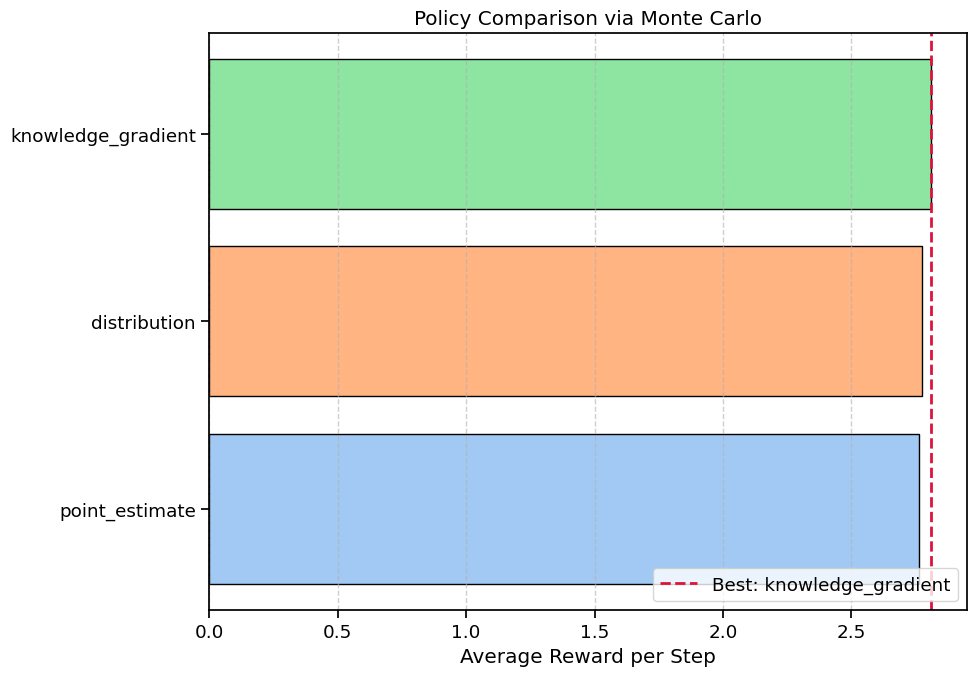

In [49]:
# --- Plot: Bar Chart ---
plt.style.use("default")
sns.set_context("notebook", font_scale=1.2)
sns.set_palette("colorblind")

plt.figure(figsize=(10, 7))
plt.barh(df["policy"], df["avg_per_step"], color=sns.color_palette("pastel"), edgecolor="black")
best_row = df.iloc[-1]
plt.axvline(best_row["avg_per_step"], color="crimson", linestyle="--", linewidth=2,
            label=f"Best: {best_row['policy']}")
plt.xlabel("Average Reward per Step")
plt.title("Policy Comparison via Monte Carlo")
plt.grid(True, axis="x", linestyle="--", alpha=0.6)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

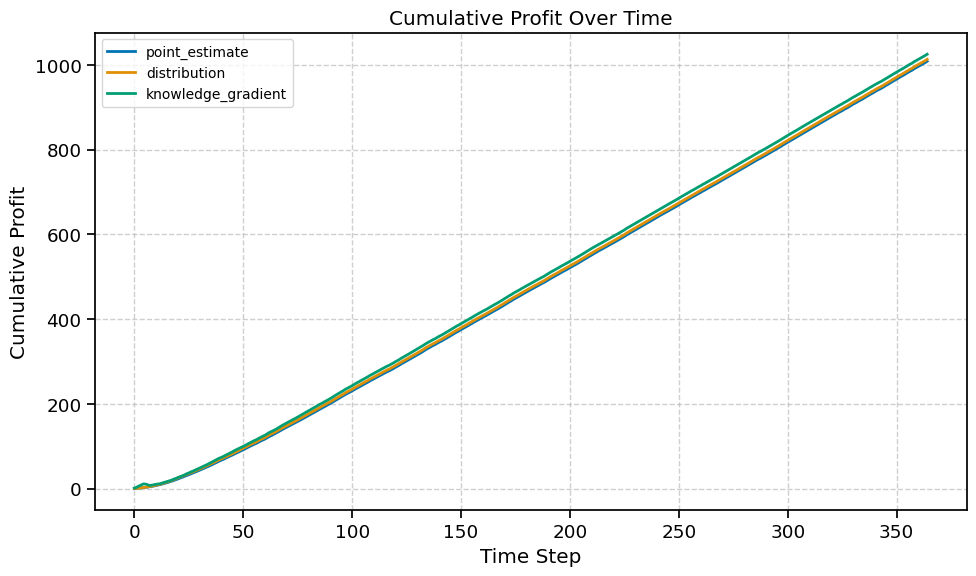

In [50]:
# --- Plot: Cumulative Profit over Time (All Policies) ---
plt.figure(figsize=(10, 6))

for d in policy_data:
    # Compute mean cumulative profit over simulations
    cumulative_rewards = np.cumsum(d["rewards"], axis=1)  # shape (N_sim, N)
    mean_cumulative = cumulative_rewards.mean(axis=0)     # shape (N,)

    plt.plot(mean_cumulative, label=d["name"], linewidth=2)

plt.title("Cumulative Profit Over Time")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Profit")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=10, loc="upper left")
plt.tight_layout()
plt.show()


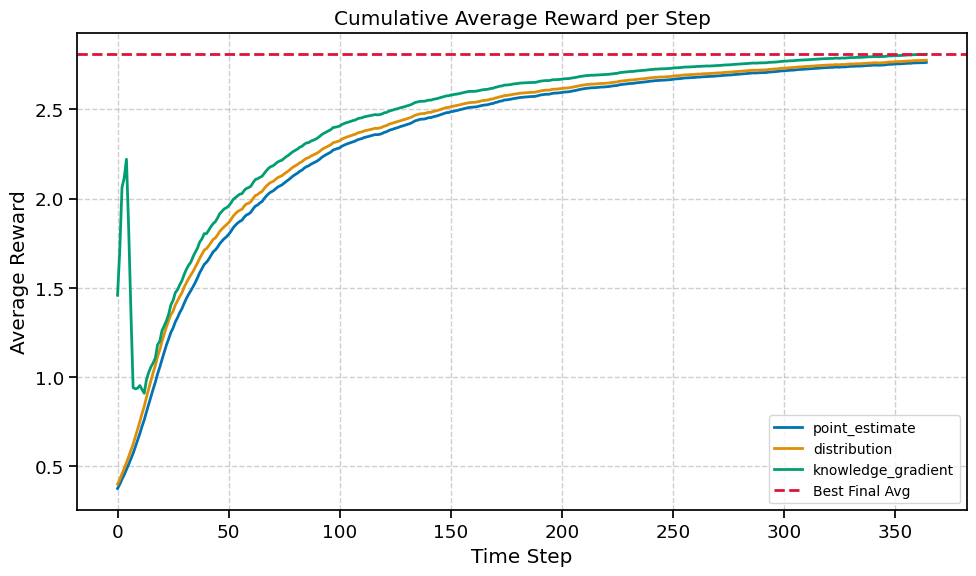

In [51]:
# --- Plot: Cumulative Average Reward per Step (All Policies) ---
plt.figure(figsize=(10, 6))
for d in policy_data:
    mean_rewards = d["rewards"].mean(axis=0)  # shape (N,)
    cum_avg_reward = np.cumsum(mean_rewards) / np.arange(1, N + 1)
    plt.plot(cum_avg_reward, label=d["name"], linewidth=2)

plt.axhline(df["avg_per_step"].max(), color="crimson", linestyle="--", linewidth=2, label="Best Final Avg")
plt.title("Cumulative Average Reward per Step")
plt.xlabel("Time Step")
plt.ylabel("Average Reward")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=10, loc="lower right")
plt.tight_layout()
plt.show()

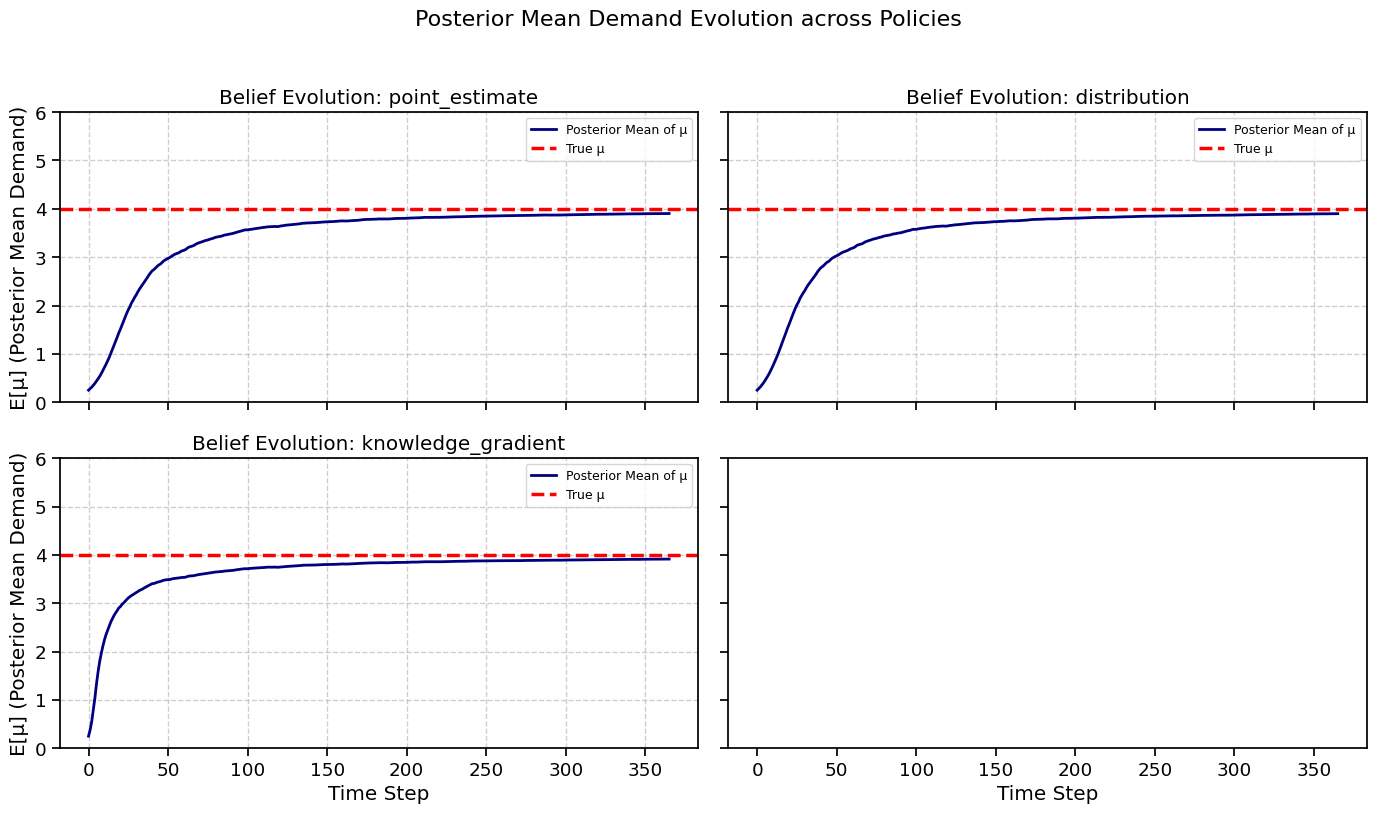

In [52]:
true_mu = 1 / lambda_true
cols = 2
rows = (len(policy_data) + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True, sharey=True)
axes = np.atleast_2d(axes)

for idx, d in enumerate(policy_data):
    ax = axes[idx // cols, idx % cols]

    a_mean = d["a_traj"].mean(axis=0)
    b_mean = d["b_traj"].mean(axis=0)
    mu_posterior_mean = b_mean / a_mean

    ax.plot(mu_posterior_mean, label="Posterior Mean of μ", color="navy", linewidth=2)
    ax.axhline(true_mu, color="red", linestyle="--", linewidth=2.5, label="True μ")

    ax.set_title(f"Belief Evolution: {d['name']}")
    ax.set_ylim(0, max(true_mu * 1.5, np.max(mu_posterior_mean) * 1.1))
    ax.grid(True, linestyle="--", alpha=0.6)

    # De-duplicate legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=9)

# Axis labels
for r in range(rows):
    for c in range(cols):
        if r == rows - 1:
            axes[r, c].set_xlabel("Time Step")
        if c == 0:
            axes[r, c].set_ylabel("E[μ] (Posterior Mean Demand)")

plt.suptitle("Posterior Mean Demand Evolution across Policies", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()